# HW1: Autoregressive Models
**Jin Yeom**  
jin.yeom@hudl.com

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm

## Warmup

First, run the following code. It will generate a dataset of samples $x \in \{1, . . . , 100\}$.

In [2]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [3]:
data = sample_data()

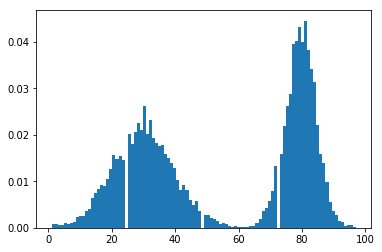

In [4]:
plt.hist(data, 100, density=True)
plt.show()

Take the first 80% of the samples as a training set and the remaining 20% as a test set.

In [5]:
training_set = data[:int(len(data)*0.8)] 
test_set = data[int(len(data)*0.8):]

Let $\theta = (\theta_{1}, ..., \theta_{100}) \in \mathbb{R}^{100}$, and define the model

$$
p_{\theta}(x) = \frac{e^{\theta_{x}}}{\sum_{x'}{e^{\theta_{x'}}}}
$$

Fit $p_{\theta}$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

In [6]:
theta = tf.Variable(np.zeros(100), name='theta')

In [7]:
def nll(probs, x):
    dist = tfp.distributions.Categorical(probs=probs)
    return tf.cast(tf.reduce_mean(-dist.log_prob(x), axis=0), tf.float32)

In [8]:
def valid_data():
    count = 2000
    rand = np.random.RandomState(23)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [9]:
validation_set = tf.constant(valid_data())

Over the course of training, record the average negative log likelihood of the training data (per minibatch) and validation data (for your entire validation set). Plot both on the same graph &ndash; the x-axis should be training setps, and the y-axis should be negative log likelihood; feel free to compute and report the validation performance less frequently. Report the test set performance of your final model. Be sure to report all negative log likelihoods in bits.

In [10]:
def minibatches(data, batch_size):
    perm = np.random.permutation(training_set)
    for i in range(0, len(training_set), batch_size):
        yield tf.constant(perm[i:i+batch_size])

In [11]:
def nat2bit(x):
    return np.log2(np.exp(x))

In [12]:
global_iter = 0
train_losses = []
valid_losses = []
optimizer = tf.optimizers.Adam(learning_rate=2e-3)
for ep in tqdm(range(50)):
    for i, batch in enumerate(tqdm(minibatches(training_set, 64), leave=False)):
        with tf.GradientTape() as tape:
            probs = tf.math.softmax(theta)
            loss = nll(probs, batch)
        # record learning statistics
        loss_bits = nat2bit(loss.numpy())
        train_losses.append((global_iter, loss_bits))
        if i % 20 == 0:
            loss_bits = nat2bit(nll(probs, validation_set).numpy())
            valid_losses.append((global_iter, loss_bits))
        # update model
        grads = tape.gradient(loss, theta)
        optimizer.apply_gradients([(grads, theta)])
        global_iter += 1
probs = tf.math.softmax(theta)
test_loss = nat2bit(nll(probs, tf.constant(test_set)).numpy())
print("test loss =", test_loss)


test loss = 5.817685


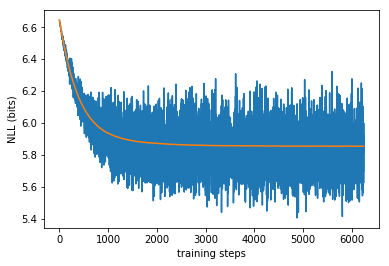

In [13]:
plt.xlabel('training steps')
plt.ylabel('NLL (bits)')
plt.plot(*tuple(zip(*train_losses)))
plt.plot(*tuple(zip(*valid_losses)))
plt.show()

Plot the model probabilities in a bar graph, which $\{1, ..., 100\}$ on the x-axis and a real number in $[0, 1]$ on the y-axis. Next, draw 1000 samples from your model, and plot their empirical frequencies on a new bar graph with the same axes. How do both compare visually to the data distribution?

In [14]:
probs = tf.math.softmax(theta).numpy()

In [15]:
dist = tfp.distributions.Categorical(probs=probs)
samples = [dist.sample() for i in range(1000)]

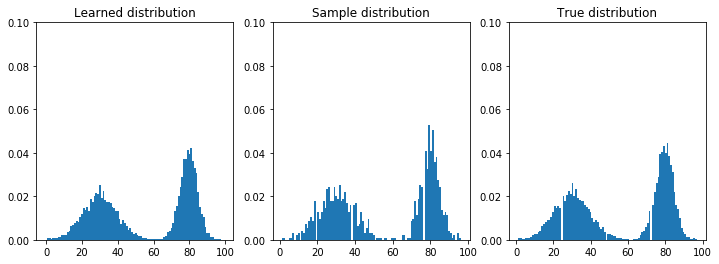

In [16]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.set_title("Learned distribution")
ax1.set_ylim([0, 0.1])
ax1.bar(np.arange(100), probs, width=1.0)
ax2.set_title("Sample distribution")
ax2.set_ylim([0, 0.1])
ax2.hist(samples, 100, density=True)
ax3.set_title("True distribution")
ax3.set_ylim([0, 0.1])
ax3.hist(data, 100, density=True)
plt.show()

Our model seems to have generally learned the distribution of the data. However, it failed to capture the masked values that do not appear in the true distribution ($p(x) = 0$).

## Two-dimensional data

In this problem, you will work with bivariate data of the form $\mathbf{x} = (x_{1}, x_{2})$, where $x_{1}, x_{2} \in \{0, 1, ..., 199\}$. In the file called `distribution.npy`, you are provided with a 2-dimensional array of floating point numbers representing the joint distribution of $\mathbf{x}$: element $(i, j)$ of this array is the joint probability $p_{data}(x_{1} = i, x_{2} = j)$.

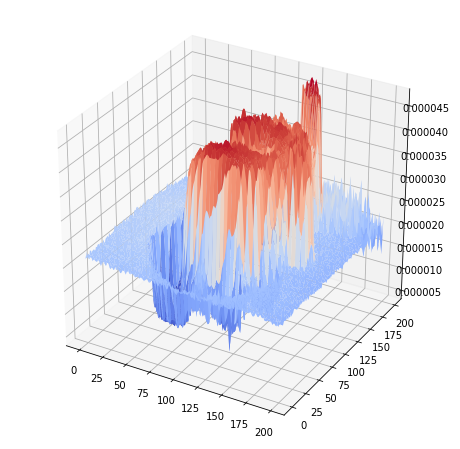

In [17]:
dist = np.load('distribution.npy')

fig = plt.figure(figsize=(8, 8))
x1 = np.arange(200)
x2 = np.arange(200)
x1, x2 = np.meshgrid(x1, x2)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, dist, cmap=cm.coolwarm)
plt.show()

Sample a dataset of 100,000 points from this distribution.

In [18]:
def sample_data2():
    count = 100000
    data = np.load('distribution.npy')
    xs = np.random.choice(40000, count, p=data.ravel())
    return np.array([(x//200, x%200) for x in xs])

In [19]:
data2 = sample_data2()

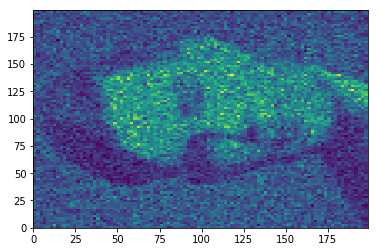

In [20]:
# NOTE: `plt.hist2d` takes (x, y) as arguments
# but we're giving it (r, c), which is (y, x).
plt.hist2d(*tuple(zip(*data2)), bins=100)
plt.show()

Oh, hi Alan.

Treat the first 80% as a training set and the remaining 20% as a test set.

In [21]:
training_set = data2[:int(len(data2)*0.8)] 
test_set = data2[int(len(data2)*0.8):]

Implement and train both of these models for this data:

1. $p_{\theta}(\mathbf{x}) = p_{\theta}(x_{1})p_{\theta}(x_{2}|x_{1})$, where $p_{\theta}(x_{1})$ is a distribution represented in the same way as in part 1, and $p_{\theta}(x_{2}|x_{1})$ is a multilayer perceptron (MLP) that takes $x_{1}$ as input and produces a distribution over $x_{2}$. (You have some freedom in designing the architecture of this MLP. For example, it can read the $x_{1}$ input either as a real number or as a one-hot vector. Experiment with such designs and pick what works best on validation data.)


2. $p_{\theta}(\mathbf{x})$ represented as a Masked Autoencoder for Distribution Estimation (MADE).

Fit both models with maximum likelihood, paying attention to performance on a validation set.

In [22]:
theta_1 = tf.Variable(np.zeros(200), name='theta_1')

In [23]:
p_x2_x1 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_shape=(200,), activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(200, activation='softmax')
])

In [26]:
global_iter = 0
train_losses = []
valid_losses = []
optimizer = tf.optimizers.Adam(learning_rate=2e-3)
for ep in tqdm(range(50)):
    for i, batch in enumerate(tqdm(minibatches(training_set, 64), leave=False)):
        x1 = batch[:, 0]
        x2 = batch[:, 1]
        with tf.GradientTape() as tape:
            probs_x1 = tf.math.softmax(theta_1)
            cond_probs_x2 = p_x2_x1(tf.one_hot(x1, 200))
            loss = nll(probs_x1, x1) + nll(cond_probs_x2, x2)
        # record learning statistics
        loss_bits = nat2bit(loss.numpy())
        train_losses.append((global_iter, loss_bits))
        if i % 20 == 0:
            x1 = test_set[:, 0]
            x2 = test_set[:, 1]
            probs_x1 = tf.math.softmax(theta_1)
            cond_probs_x2 = p_x2_x1(tf.one_hot(x1, 200))
            test_loss = nll(probs_x1, x1) + nll(cond_probs_x2, x2)
            loss_bits = nat2bit(test_loss.numpy())
            valid_losses.append((global_iter, loss_bits))
        # update model
        thetas = [theta_1] + p_x2_x1.variables
        thetas = p_x2_x1.variables
        grads = tape.gradient(loss, thetas)
        optimizer.apply_gradients(zip(grads, thetas))
        global_iter += 1

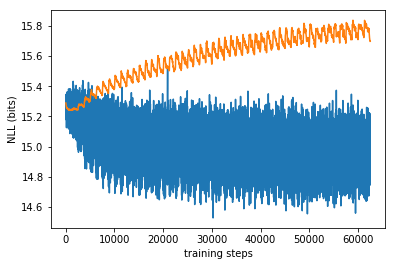

In [27]:
plt.xlabel('training steps')
plt.ylabel('NLL (bits)')
plt.plot(*tuple(zip(*train_losses)))
plt.plot(*tuple(zip(*valid_losses)))
plt.show()